# Forecasting Molecule

In [51]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# from scipy.stats import ttest_rei
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX






## Preprocessing

In [53]:
df = pd.read_excel('../test_data_working_students.xlsx')
df.head()

,Record ID,year,month,MoleculeName,TradeName,ProductName,Packs,Value
0,1,2017,12,molecule1,brand1,SKU1,2966.0,32504.671461
1,2,2017,12,molecule2,brand2,SKU2,7675.0,5627.328111
2,3,2017,12,molecule2,brand2,SKU3,24404.0,10741.583225
3,4,2017,12,molecule3,brand3,SKU4,14775.0,65098.087341
4,5,2017,12,molecule3,brand3,SKU5,18206.0,61614.771981


In [54]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
# df.set_index('date', inplace=True)

target_col = "Value"
ts = df[target_col].dropna()

df['month_of_year'] = df['month']     
df['quarter'] = df['date'].dt.quarter  
df['week_of_year'] = df['date'].dt.isocalendar().week  


df['Value_Lag1']= df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].shift(1)
df['Packs_Lag1']= df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].shift(1)     
  
df['Value_Rolling_3'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].transform(lambda x: x.rolling(3).mean()) 
df['Packs_Rolling_3'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].transform(lambda x: x.rolling(3).mean())   
df['Value_Rolling_6'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Value'].transform(lambda x: x.rolling(6).mean()) 
df['Packs_Rolling_6'] = df.groupby(['MoleculeName', 'TradeName', 'ProductName'])['Packs'].transform(lambda x: x.rolling(6).mean())    

#drop the nan values from lags/rolling transformations
# df.dropna(subset=['Value_Lag1', 'Packs_Lag1', 'Value_Rolling_3', 'Packs_Rolling_3', 'Value_Rolling_6', 'Packs_Rolling_6'], inplace=True)   
df.dropna(inplace=True)

 
encoder= OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['MoleculeName', 'TradeName', 'ProductName']])
df = df.reset_index(drop=True)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['MoleculeName', 'TradeName', 'ProductName']))
df= pd.concat([df, encoded_df], axis=1)   


c:\Users\annap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
target_value = 'Value'
target_packs = 'Packs'  

features = ['year', 'month','month_of_year','quarter', 'week_of_year', 'Value_Lag1','Packs_Lag1','Value_Rolling_3', 'Packs_Rolling_3', 'Value_Rolling_6','Packs_Rolling_6'] + list(encoded_df.columns)   

X= df[features]   
y_value = df[target_value]  
y_packs = df[target_packs]        

tscv = TimeSeriesSplit(n_splits=5) 
scaler = StandardScaler()


## Models

In [56]:
def evaluate_model(model, X, y, tscv, param_grid=None):
    mse_scores = []   
    all_residuals = []
    best_model = None

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test= X.iloc[train_idx], X.iloc[test_idx] 
        y_train, y_test= y.iloc[train_idx], y.iloc[test_idx] 

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        print(f"Training set size: {X_train_scaled.shape},  Test set size: {X_test_scaled.shape}")


        # X_train = X_train.values
        # X_test = X_test.values
        # X.columns = X.columns.astype(str)

        # print(f"Training set size: {X_train.shape},  Test set size: {X_test.shape}")

        if param_grid is not None: 
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters: {grid_search.best_params_}")
        else:
            best_model=model 
            best_model.fit(X_train_scaled, y_train)
              
        y_pred = best_model.predict(X_test_scaled)
        residuals = y_test - y_pred   

        mse = mean_squared_error(y_test, y_pred) 
        mse_scores.append(mse)  

        all_residuals.append(pd.DataFrame({"y_test": y_test,"y_pred": y_pred, "residuals": residuals}))  

    
    mean_mse = np.mean(mse_scores)    
    print(f'Mean MSE:  {mean_mse}')  

    return best_model, mean_mse, pd.concat(all_residuals)   



### Linear Regression

In [57]:
ts = ts.reset_index()
ts['time_index'] = np.arange(len(ts))
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]  


lin_reg = LinearRegression() 
lin_reg.fit(train[["time_index"]], train[target_col])
preds_lr = lin_reg.predict(test[["time_index"]])

mse_lr = mean_squared_error(test[target_col], preds_lr)    
print(f"Linear Regression MSE: {mse_lr}") 

Linear Regression MSE: 95503663576.30641


### ARIMA

In [58]:
arima_model = ARIMA(train[target_col], order=(1,1,1)).fit()
preds_arima = arima_model.forecast(len(test))

mse_arima = mean_squared_error(test[target_col], preds_arima)
print(f"ARIMA MSE: {mse_arima}")

ARIMA MSE: 93380648532.49261


### XGBoost

#### Value

In [ ]:
X['week_of_year'] = X['week_of_year'].astype('int32')
X = X.astype({col: 'int32' for col in X.select_dtypes(include='Int64').columns})

X.fillna(0, inplace=True)
non_numeric_cols = X.select_dtypes(exclude=['number']).columns


param_grid_xgboost = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
    'early_stopping_rounds': [10, 20, 30],
    'min_child_weight': [1, 3, 5],
    'objective': ['reg:squarederror', 'binary:logistic'],  
    'booster': ['gbtree', 'dart'],
    'tree_method': ['auto', 'exact', 'approx', 'hist']
}
   



C:\Users\annap\AppData\Local\Temp\ipykernel_9268\1432527895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['week_of_year'] = X['week_of_year'].astype('int32')


In [ ]:
xg_reg_value = xgb.XGBRegressor(objective='reg:squarederror', 
                                n_estimators=100, 
                                learning_rate=0.1, 
                                enable_categorical=False)
xgboost_model_value, xg_mse_value, xg_residuals_value = evaluate_model(xg_reg_value, X, y_value, tscv, param_grid_xgboost)
print(f'XGBoost MSE for Value: {xgboost_model_value}')

Training set size: (586, 247),  Test set size: (581, 247)


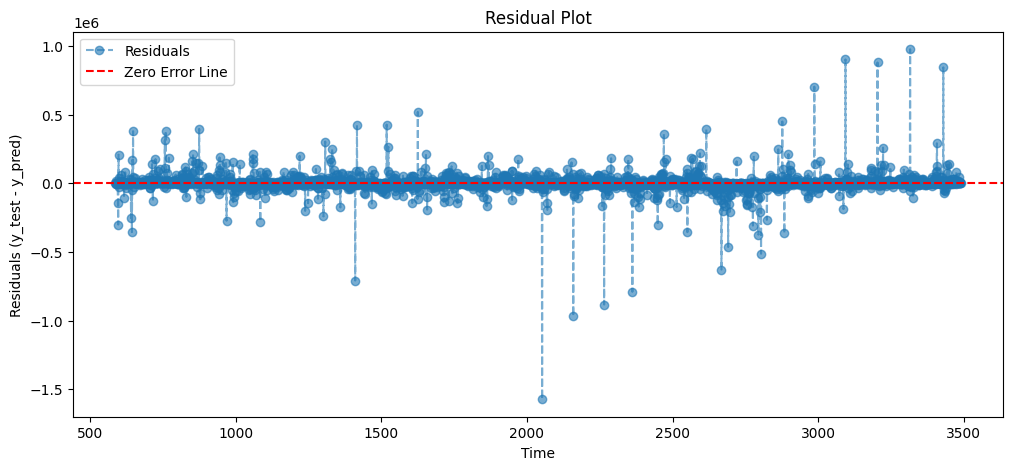

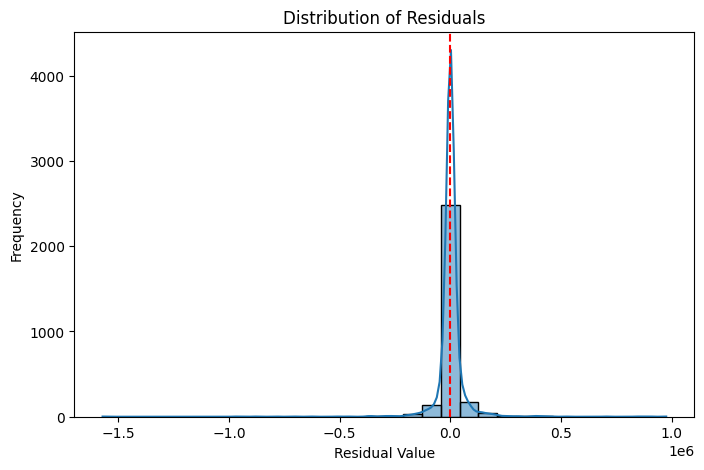

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(xg_residuals_value.index, xg_residuals_value["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(xg_residuals_value["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals - Value")
plt.show()

In [ ]:
importances_value = xgboost_model_value.feature_importances_
feature_names = X.columns

feat_imp_df_value = pd.DataFrame({'Feature': feature_names, 'Importance': importances_value})
feat_imp_df_value = feat_imp_df_value.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_value.Importance[:20], y=feat_imp_df_value.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in XGBoost - Value")  
plt.show()  
   

#### Packs

In [ ]:
xg_reg_pack = xgb.XGBRegressor(objective='reg:squarederror', 
                                n_estimators=100, 
                                learning_rate=0.1, 
                                enable_categorical=False)
xgboost_model_pack, xg_mse_pack, xg_residuals_pack = evaluate_model(xg_reg_pack, X, y_packs, tscv, param_grid_xgboost)
print(f'XGBoost MSE for Pack: {xgboost_model_pack}')

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(xg_residuals_pack.index, xg_residuals_pack["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Packs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(xg_residuals_pack["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Packs")
plt.show()

In [ ]:
importances_packs = xgboost_model_pack.feature_importances_
feature_names = X.columns

feat_imp_df_packs = pd.DataFrame({'Feature': feature_names, 'Importance': importances_packs})
feat_imp_df_packs = feat_imp_df_packs.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_packs.Importance[:20], y=feat_imp_df_packs.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in XGBoost - Packs")  
plt.show()  
   

### Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], 
    'bootstrap': [True, False],
    'criterion':['mse', 'mae'],
    'max_samples': [0.8, 1.0],  
    'oob_score': [True, False],
}

#### Value

In [ ]:
rf_reg_value = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_model_value, rf_mse_value, rf_residuals_value= evaluate_model(rf_reg_value, X, y_value, tscv, param_grid_rf)
print(f'Random Forest MSE for Packs: {rf_mse_value}')

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(rf_residuals_value.index, rf_residuals_value["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(rf_residuals_value["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals - Value")
plt.show()

In [ ]:
importances_value = rf_model_value.feature_importances_
feature_names = X.columns

feat_imp_df_value = pd.DataFrame({'Feature': feature_names, 'Importance': importances_value})
feat_imp_df_value = feat_imp_df_value.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_value.Importance[:20], y=feat_imp_df_value.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in RF - Value")  
plt.show()  
   

#### Packs

In [ ]:
rf_reg_packs = RandomForestRegressor(n_estimators=100, oob_score=True)
rf_model_packs, rf_mse_packs, rf_residuals_packs = evaluate_model(rf_reg_packs, X, y_packs, tscv, param_grid_rf)
print(f'Random Forest MSE for Packs: {rf_mse_packs}')

Training set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean MSE:  143474801.98031405
Random Forest MSE for Packs: 14

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(rf_model_packs.index, rf_model_packs["residuals"], marker='o', linestyle='dashed', alpha=0.6, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Time")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Residual Plot - Packs")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(rf_model_packs["residuals"], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")  
plt.title("Distribution of Residuals - Packs")
plt.show()

In [ ]:
importances_packs = rf_model_packs.feature_importances_
feature_names = X.columns

feat_imp_df_packs = pd.DataFrame({'Feature': feature_names, 'Importance': importances_packs})
feat_imp_df_packs = feat_imp_df_packs.sort_values(by="Importance", ascending=False)  


plt.figure(figsize=(12, 6)) 
sns.barplot(x=feat_imp_df_packs.Importance[:20], y=feat_imp_df_packs.Feature[:20])
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Feature Importances in RF - Packs")  
plt.show()  
   

raining set size: (586, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (1167, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training set size: (1748, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training set size: (2329, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training set size: (2910, 247),  Test set size: (581, 247)
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean MSE:  143474801.98031405
Random Forest MSE for Packs: 143474801.98031405

## SARIMA